# Aleatoric Uncertainty

## Generate Fake Regression Dataset with one Feature

#### Train set


This is a heteroscedastic dataset (variance changes for samples).

In the following we want to estimate the variance based on the training data (conditioned on the inputs).

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
import math
import numpy as np
figure(figsize=(7, 7))

# Same range for all plots
plt.xlim([-10, 10])
start = -7
end = 7
n = 300

def sample_dataset(start, end, n):
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=1)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

In [ ]:
figure(figsize=(7, 7))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

Put data into Tensor Datasets

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Maximum likelihood Estimation

In regression the most commonly used loss function is the mean squared error function. If we were to take the negative of this loss and exponentiate it, the result would correspond to the gaussian distribution. The mode of this distribution (the peak) corresponds to the mean parameter.

### Simple Neural Network that predicts mean and variance
- We output variance here, because our loss function expects var = sigma**2 (instead of just sigma)
- We could also use just one Linear output layer with 2 neurons

In [ ]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 64

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        mu = self.mu(h)
        # Exponential activation to enforce positive var
        # Arash: this might be a significant difference:
        var = torch.exp(self.var(h))
        return mu, var

net = SimpleNet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

In [ ]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(5, 5)})

def make_plot(model):
    # Get predictions
    mu, var = model(tensor_x_test)
    mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)

    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()

### Train

- There are different variants for the loss. We will simply use the in pytorch already implemented [Gaussian Negative Log Likelihood]
(https://pytorch.org/docs/stable/generated/torch.nn.GaussianNLLLoss.html)
- __Arash__: This is another improvement, see the link, they have guards against very small sigma values that we did not implement. 
- The standard NLL Loss is only suited for classification problems
- [Implementation details here](https://towardsdatascience.com/knowing-known-unknowns-with-deep-neural-networks-caac1c4c1f5d)
- Another approach is to sample from the Gaussian distribution that is defined by mu/sigma and use MSE
- If we train too long it starts to overfit on the train data

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loss expects mean, variance and target
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
net.train()
net.to(device)

In [ ]:
for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu, var = net(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot(net)

## Mixture Density Network (also MLE)

- Great implementations can be found [here](https://deep-and-shallow.com/2021/03/20/mixture-density-networks-probabilistic-regression-for-uncertainty-estimation/) and [here](https://gitlab.cs.fau.de/oc81adow/pytorch-mdn/-/blob/master/mdn/mdn.py)
- Applying a MDN doesn't make too much sense for our dataset, as we have simple gaussian variance (an not for example multimodal)
- If you don't know how the uncertainty of the target variable is distributed, using a MDN can be very helpful





In [ ]:
class MDN(nn.Module):
    def __init__(self):
        super(MDN, self).__init__()
        hidden_size = 64
        self.num_gaussians = 3

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, self.num_gaussians)
        self.sigma = nn.Linear(hidden_size, self.num_gaussians)
        self.alpha = nn.Linear(hidden_size, self.num_gaussians)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        mus = self.mu(h)
        sigmas = torch.exp(self.sigma(h))
        alphas = F.softmax(self.alpha(h), dim=1)
        return mus, sigmas, alphas
mdn = MDN()

In [ ]:
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions import Categorical, Normal

def make_plot_mdn(model):
    # Get predictions
    mus, sigmas, alphas = model(tensor_x_test)

    # Define distribution with these parameters
    gmm = MixtureSameFamily(
            mixture_distribution=Categorical(probs=alphas),
            component_distribution=Normal(
                loc=mus,
                scale=sigmas))
    mean = gmm.mean.detach().numpy()
    var = gmm.variance.detach().numpy()


    y_vals = [mean, mean+2*var**(1/2), mean-2*var**(1/2)]
    dfs = []

    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot means
    for i in range(model.num_gaussians):
        scatter(x_test, mus[:, i].detach().numpy(), alpha=0.3, s=4)

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")
    plt.axvline(x=start)
    plt.axvline(x=end)
    scatter(x_test, y_test, c="green", marker="*", alpha=0.3)
    plt.show()

Loss function from [here](https://towardsdatascience.com/a-hitchhikers-guide-to-mixture-density-networks-76b435826cca) adjusted to Pytorch.

In [ ]:
def mdn_loss(mu, y, sigma, alphas):
    gmm = MixtureSameFamily(
            mixture_distribution=Categorical(probs=alphas),
            component_distribution=Normal(
                loc=mu,
                scale=sigma))
    log_likelihood = gmm.log_prob(y.t())
    return -torch.mean(log_likelihood, axis=1)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(mdn.parameters(), lr=0.0005)
criterion = mdn_loss
mdn.train()
mdn.to(device)
for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mus, sigmas, alphas = mdn(x)
        loss = criterion(mus, y, sigmas, alphas)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mus, sigmas, alphas = mdn(x)
             all_test_losses.append(criterion(mus, y, sigmas, alphas).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss.item()} | test loss: {test_loss}")
        make_plot_mdn(mdn)

## Quantile Regression
- Some of the implementation details from [here](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a)
- In this case we know that the variance in the variable is normally distributed (and therefore we could optimize the gaussian likelihood). Here we see however that we get a pretty good approximation, even though we don't use the underlying distribution

In [32]:
class QuantileNet(nn.Module):
    def __init__(self):
        super(QuantileNet, self).__init__()
        hidden_size = 64

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.lower_quantile = nn.Linear(hidden_size, 1)
        self.median = nn.Linear(hidden_size, 1)
        self.upper_quantile = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.tanh(self.fc1(x))
        h = torch.tanh(self.fc2(h))
        lq = self.lower_quantile(h)
        med = self.median(h)
        uq = self.upper_quantile(h)
        return torch.cat([lq, med, uq], axis=1)

qnet = QuantileNet()

In [33]:
def make_plot_qnet(model):
    preds = model(tensor_x_test)
    preds = preds.detach().numpy()

    dfs = []
    # Lower / Median / Upper
    y_vals = [preds[:, 1], preds[:, 0], preds[:, 2]]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)
    plt.show()

Loss implementation from [here](https://forums.fast.ai/t/quantile-regression-prediction-intervals-confidence-intervals/58821/2).

Epoch 0 | batch train loss: 0.3469383418560028 | test loss: 1.0167343616485596


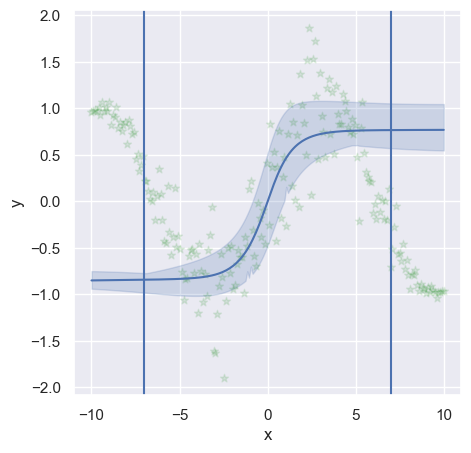

Epoch 10 | batch train loss: 0.19123242795467377 | test loss: 0.41160762310028076


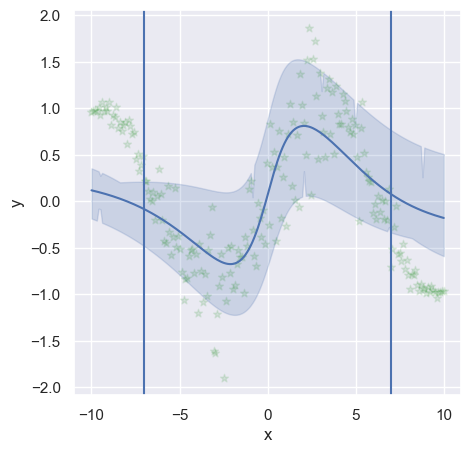

Epoch 20 | batch train loss: 0.17161037027835846 | test loss: 0.39082056283950806


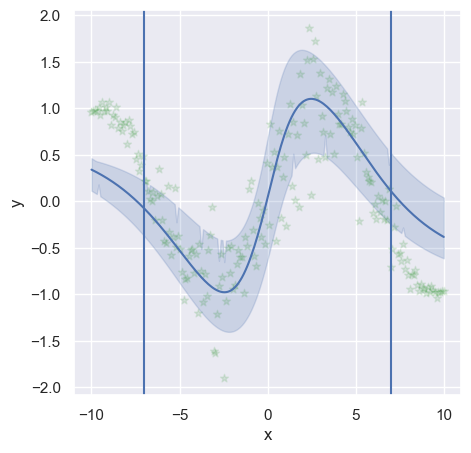

Epoch 30 | batch train loss: 0.15786190330982208 | test loss: 0.2497590184211731


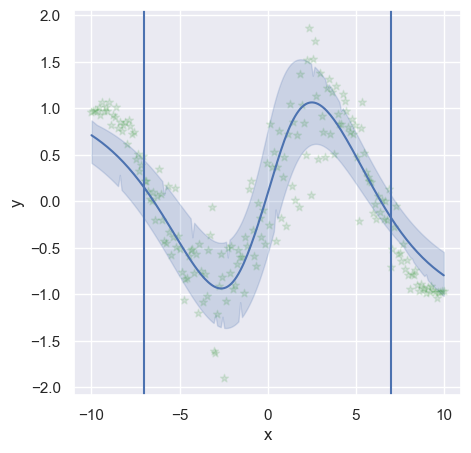

Epoch 40 | batch train loss: 0.10817364603281021 | test loss: 0.23109589517116547


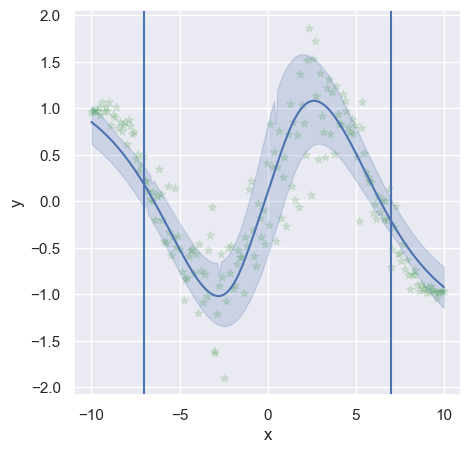

Epoch 50 | batch train loss: 0.2176438570022583 | test loss: 0.20368130505084991


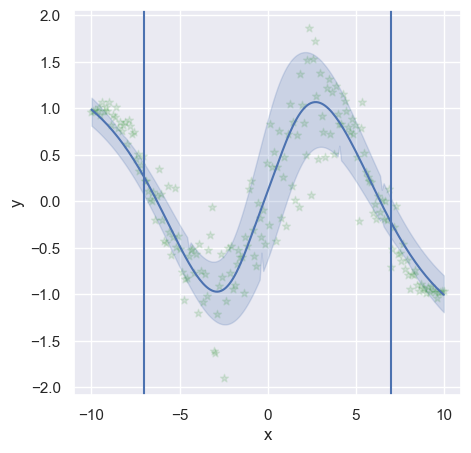

Epoch 60 | batch train loss: 0.07025296241044998 | test loss: 0.200081929564476


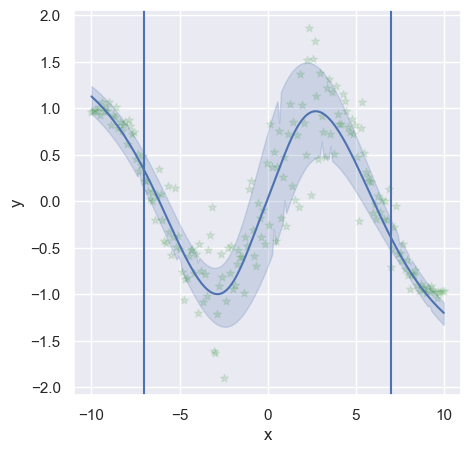

Epoch 70 | batch train loss: 0.10217741876840591 | test loss: 0.18896201252937317


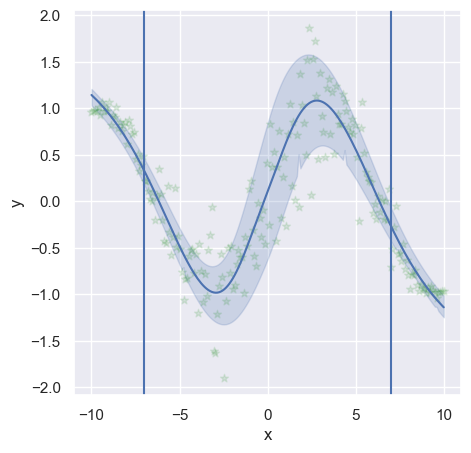

Epoch 80 | batch train loss: 0.1225094199180603 | test loss: 0.19848810136318207


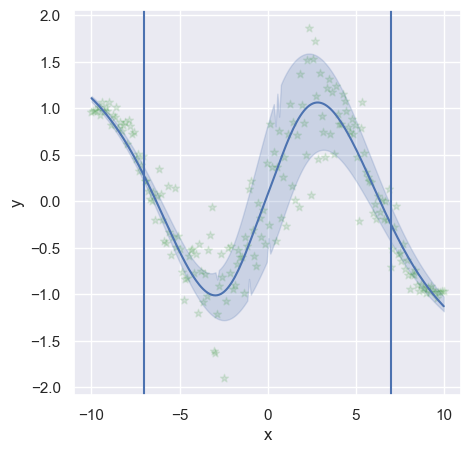

Epoch 90 | batch train loss: 0.20678390562534332 | test loss: 0.20743626356124878


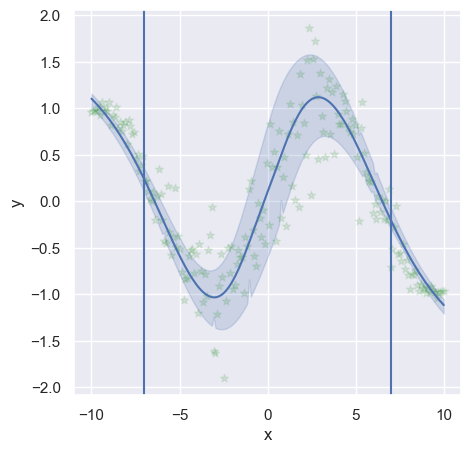

In [34]:
import torch.optim as optim
import torch.nn.functional as F

def quantile_loss(preds, target, quantiles=[0.05, 0.5, 0.95]):
    """ aka Pinball loss """
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - torch.unsqueeze(preds[:, i], 1)
        q_loss = torch.max((q-1) * errors, q * errors)
        losses.append(q_loss)
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(qnet.parameters(), lr=0.001)
criterion = quantile_loss
qnet.train()
qnet.to(device)

for epoch in range(100):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        preds = qnet(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             preds = qnet(x)
             all_test_losses.append(criterion(preds, y))
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss.item()} | test loss: {test_loss}")
        make_plot_qnet(qnet)

# Epistemic Uncertainty

```
Before you run this section, please first create the dataset in the first cell
```

## Bayesian Neural Networks

Several choices for BNNs in Pytorch:
- [Blitz](https://github.com/piEsposito/blitz-bayesian-deep-learning)
- [ProbFlow](https://probflow.readthedocs.io/en/latest/)
- [Pyro](https://docs.pyro.ai/en/stable/getting_started.html)
- [Tyxe](https://github.com/karalets/TyXe)
- [Torchbnn](hhttps://github.com/Harry24k/bayesian-neural-network-pytorch)
- and many more...

We will use Blitz in the following, because it has a very straight-forward interface. It currently supports these layers:
*   BayesianModule
*   BayesianLinear
*   BayesianConv1d
*   BayesianConv2d
*   BayesianConv3d
*   BayesianLSTM
*   BayesianGRU
*   BayesianEmbedding

In [ ]:
!pip install blitz-bayesian-pytorch


# A little bit of imports from previous section
import math
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
sns.set(rc={'figure.figsize':(5, 5)})

- The decorator allows to do bayesian-specific operations such as sampling and calculating the variational inference loss.
- Internally, the bayesian layers use for example **TrainableRandomDistribution** to represent trainable distributions over weights.
- TrainableRandomDistribution uses the reparametrization trick for sampling

In [38]:
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

@variational_estimator
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_size = 32

        self.blinear1 = BayesianLinear(1, hidden_size, prior_sigma_1=1)
        self.blinear2 = BayesianLinear(hidden_size, hidden_size, prior_sigma_1=1)
        self.blinear3 = BayesianLinear(hidden_size, 1, prior_sigma_1=1)

    def forward(self, x):
        x_ = torch.relu(self.blinear1(x))
        x_ = torch.relu(self.blinear2(x_))
        return self.blinear3(x_)

bnn = BayesianNetwork()
print(bnn)
print("Params:", sum(p.numel() for p in bnn.parameters() if p.requires_grad))

BayesianNetwork(
  (blinear1): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (blinear2): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (blinear3): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
)
Params: 4612


In [39]:
def make_plot_bnn(model, samples = 500):
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)

    plt.show()

We will use sample_elbo to sample a loss. This works as follows:
- We sample because we want to approximate the posterior (sampling-based variational inference)
- The loss consists of two parts: KL-Divergence and Likelihood
- KL-Divergence: How close we are to the prior with the current weight distribution (takes the sum)
- Likelihood: Actual loss for regression target e.g. MSE
- For variational inference the weights are sampled several times to gather an approximation for the loss
- In order to get each loss separately we call sample_elbo_detailed_loss
- complexity_cost_weight is the same as the "beta" in beta-VAEs

Epoch 0 | batch train loss: 1.3489054441452026 | test loss: 1.3285084504347582


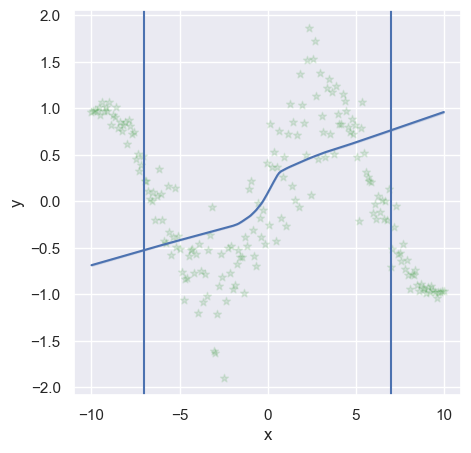

Epoch 10 | batch train loss: 0.32889989018440247 | test loss: 0.43053378279392535


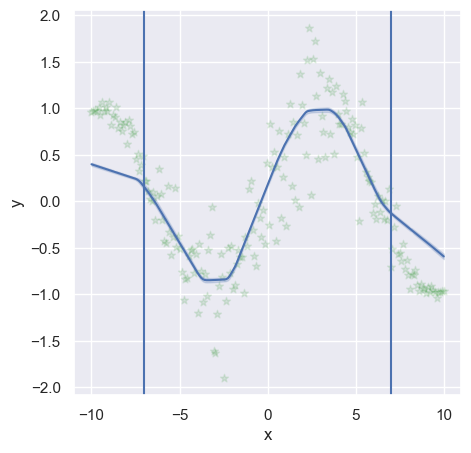

Epoch 20 | batch train loss: 0.3669814169406891 | test loss: 0.3313075281106509


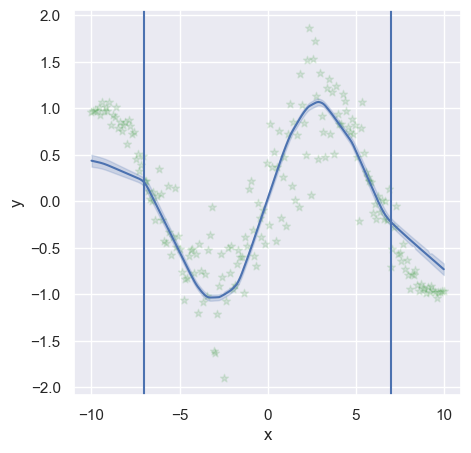

Epoch 30 | batch train loss: 0.23795567452907562 | test loss: 0.26950496205916774


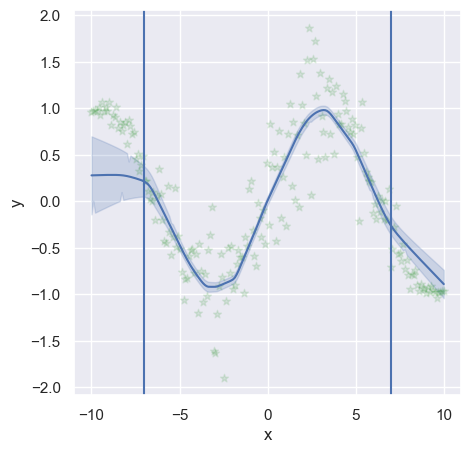

Epoch 40 | batch train loss: 0.21645045280456543 | test loss: 0.2392513075700173


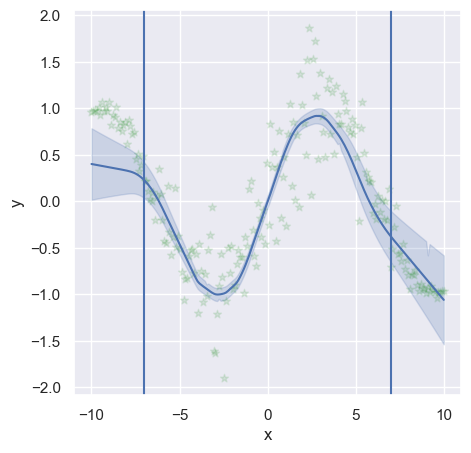

Epoch 50 | batch train loss: 0.3541703522205353 | test loss: 0.25646337752158826


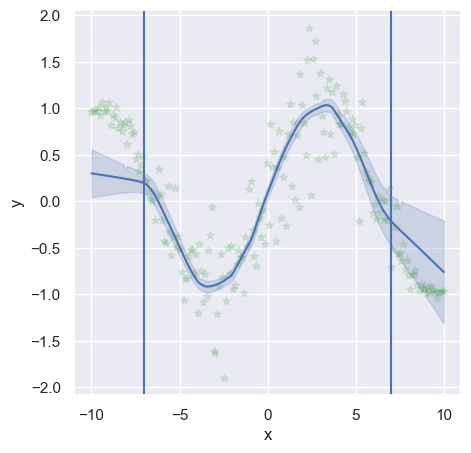

Epoch 60 | batch train loss: 0.1930665820837021 | test loss: 0.21911933215764853


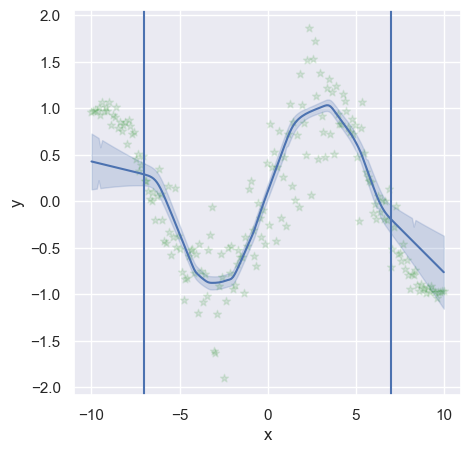

Epoch 70 | batch train loss: 0.1577654927968979 | test loss: 0.21770872061069196


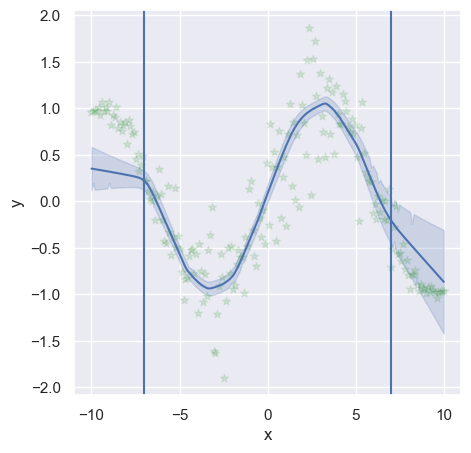

Epoch 80 | batch train loss: 0.16707904636859894 | test loss: 0.21402785181999207


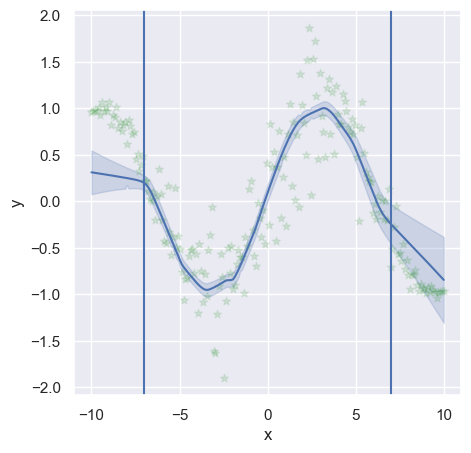

Epoch 90 | batch train loss: 0.20238429307937622 | test loss: 0.20676824622429335


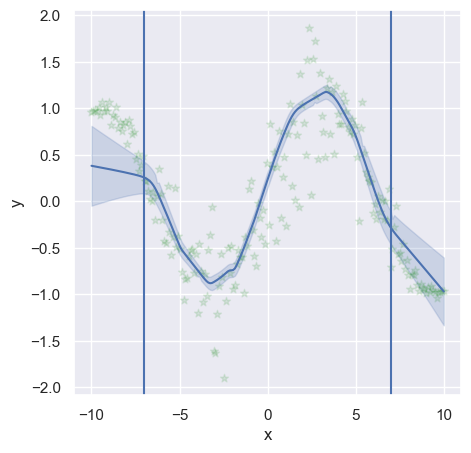

In [40]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(bnn.parameters(), lr=0.01)

bnn.train()
bnn.to(device)
for epoch in range(100):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()

        # See https://arxiv.org/pdf/1505.05424.pdf for complexity cost weight
        loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=0.01/len(train_dataset))

        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=0.01/len(test_dataset))
             all_test_losses.append(loss.item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_bnn(bnn)

## Monte Carlo Dropout

In [71]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class MCDO(nn.Module):
    def __init__(self):
        super(MCDO, self).__init__()
        hidden_size = 32

        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        h = self.dropout(torch.relu(self.fc1(x)))
        h = self.dropout(torch.relu(self.fc2(h)))
        out = self.out(h)
        return out

model = MCDO()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

MCDO(
  (fc1): Linear(in_features=1, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Params: 1153


In [73]:
def make_plot_mcdo(model, samples = 50):
    # Keep dropout active!
    model.train()
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_train, y_train, c="green", marker="*", alpha=0.1)
    plt.show()

Epoch 0 | batch train loss: 0.07036705315113068 | test loss: 0.1374341192153784


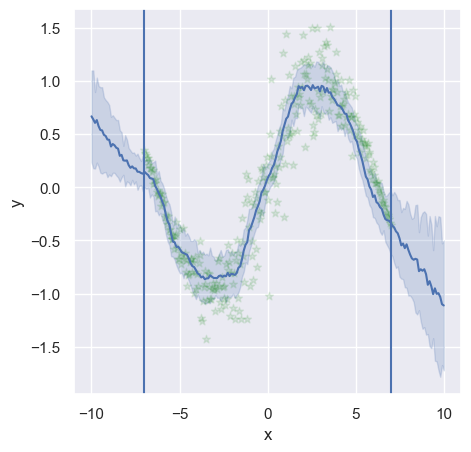

Epoch 10 | batch train loss: 0.197820782661438 | test loss: 0.1443028083214393


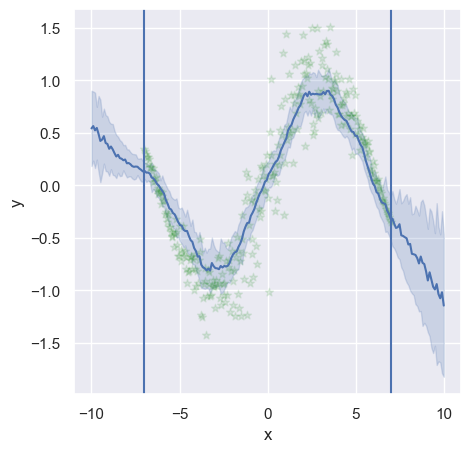

Epoch 20 | batch train loss: 0.04546638950705528 | test loss: 0.13091550767421722


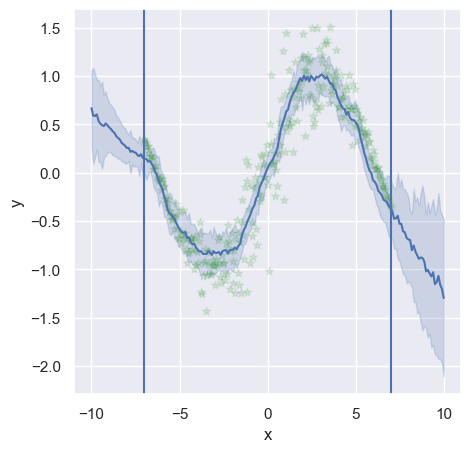

Epoch 30 | batch train loss: 0.08525804430246353 | test loss: 0.11919337797623414


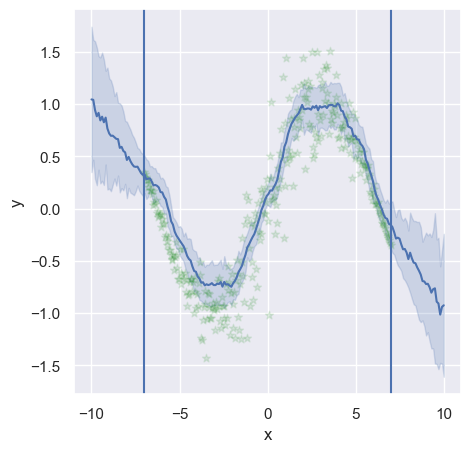

Epoch 40 | batch train loss: 0.07910114526748657 | test loss: 0.11027954404170696


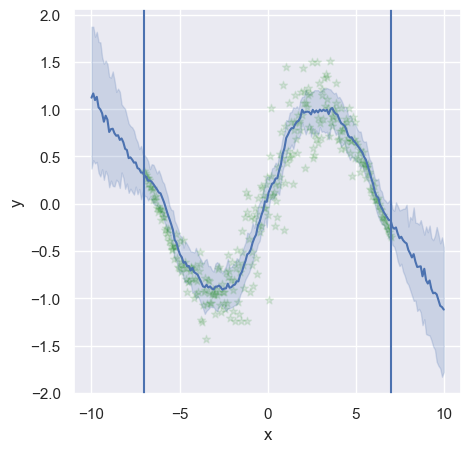

Epoch 50 | batch train loss: 0.02103554457426071 | test loss: 0.16936154233721587


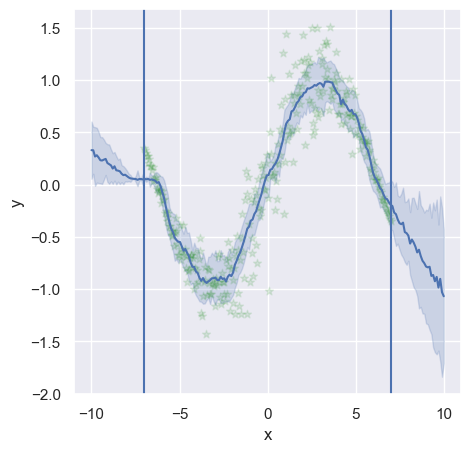

Epoch 60 | batch train loss: 0.09670346975326538 | test loss: 0.11797123459669259


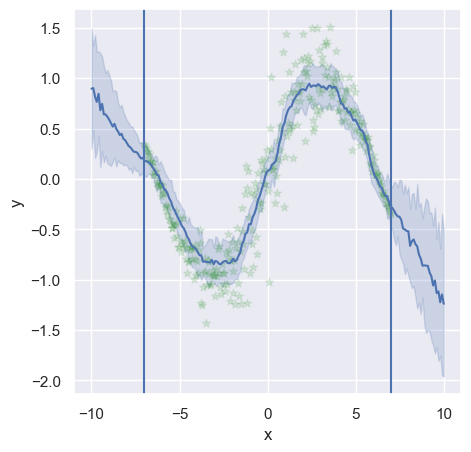

Epoch 70 | batch train loss: 0.03979925066232681 | test loss: 0.1404700170342739


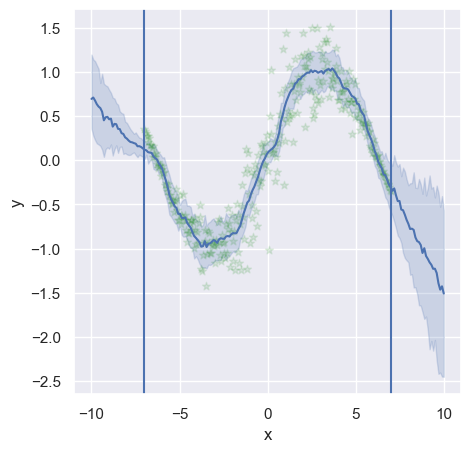

Epoch 80 | batch train loss: 0.07924675196409225 | test loss: 0.10952487874489564


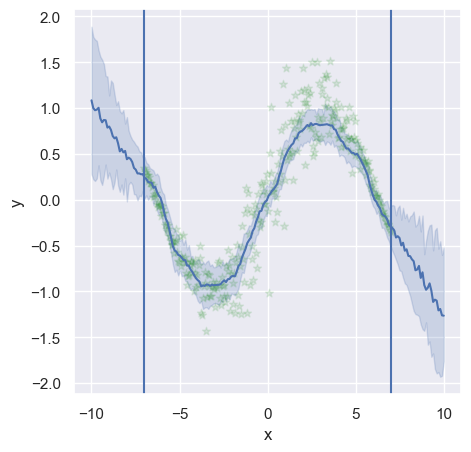

Epoch 90 | batch train loss: 0.04508642852306366 | test loss: 0.10724032928164189


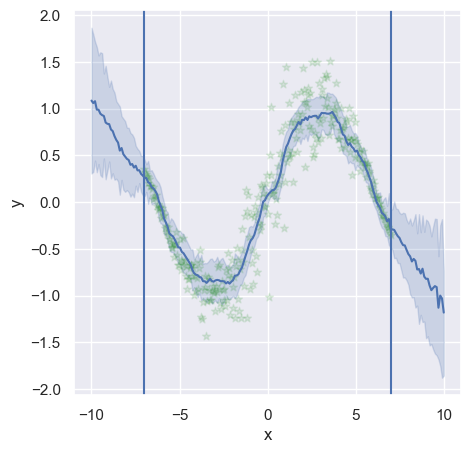

Epoch 100 | batch train loss: 0.07116633653640747 | test loss: 0.1290863471535536


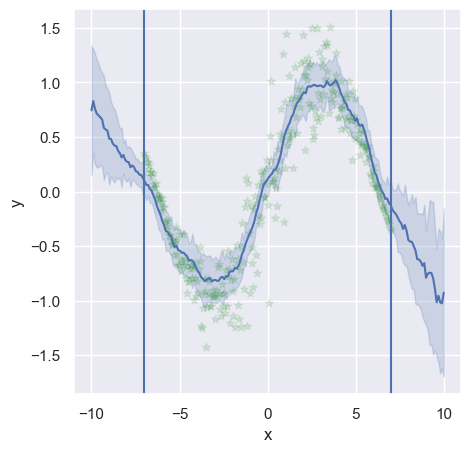

Epoch 110 | batch train loss: 0.06829270720481873 | test loss: 0.11219113893233813


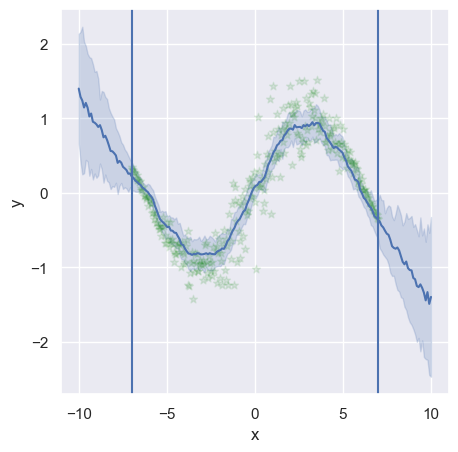

Epoch 120 | batch train loss: 0.019806386902928352 | test loss: 0.12789172478593314


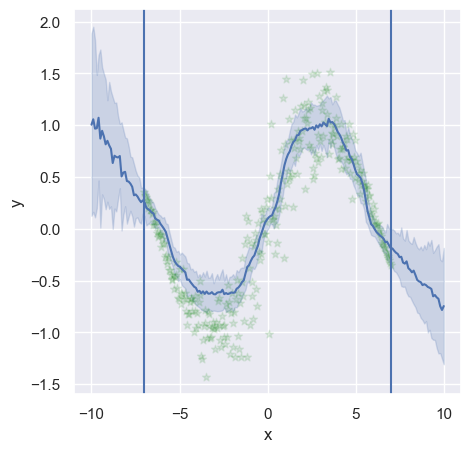

Epoch 130 | batch train loss: 0.026764413341879845 | test loss: 0.11842117000084657


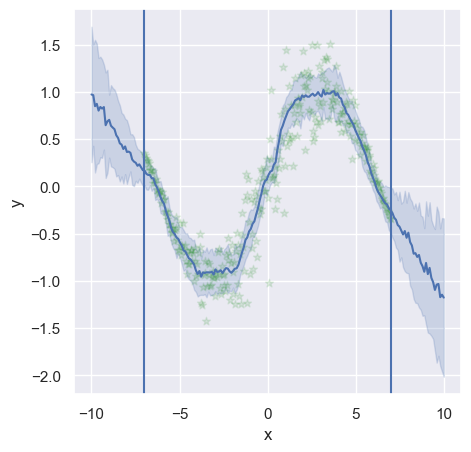

Epoch 140 | batch train loss: 0.10894948244094849 | test loss: 0.22513971821619913


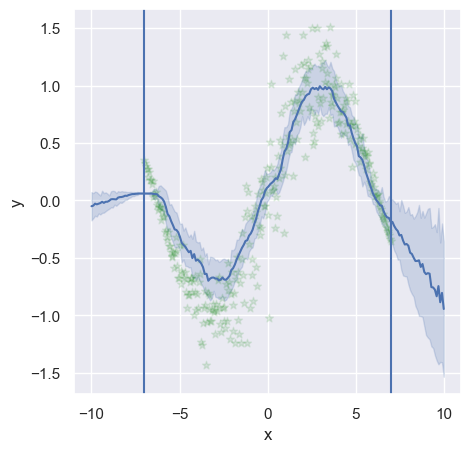

In [75]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to(device)

for epoch in range(150):
    model.train()
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(y, out)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)

             # Sample MC Dropout predictions
             outs = []
             for i in range(10):
                  model.train()  
                  out = model(x)
                  outs.append(out)

             # Take mean prediction
             out = sum(outs)/len(outs)
             all_test_losses.append(criterion(y, out).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_mcdo(model)

## Deep Ensembles
-  A deep ensemble, that predicts mean and standard deviation is effectively a Gaussian Mixture Model, because the target variable is assumed to be normally distributed

In [76]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 64

        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.mu(h)
        var = torch.exp(self.var(h))
        return mu, var

model = SimpleNet()
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

SimpleNet(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (mu): Linear(in_features=64, out_features=1, bias=True)
  (var): Linear(in_features=64, out_features=1, bias=True)
)
Params: 4418


In [77]:
def make_plot_de(model):
    mus = []
    vars = []
    for m in model:
        mu, var = m(tensor_x_test)
        mus.append(mu)
        vars.append(var)

    # For epistemic uncertainty we calculate the std on the mus!
    # Arash: note how vars is no longer used in evaluation
    means = torch.stack(mus).mean(axis=0).detach().numpy()
    stds = torch.stack(mus).std(axis=0).detach().numpy()**(1/2)

    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_train, y_train, c="green", marker="*", alpha=0.1)

    plt.show()

In [78]:
# Construct ensemble
num_models = 5
deep_ensemble = [SimpleNet().to(device) for i in range(num_models)]
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizers = [optim.Adam(m.parameters(), lr=0.001) for m in deep_ensemble]

Epoch 0 | batch train loss: -0.042726639891043305 | test loss: 1.7212763162759634


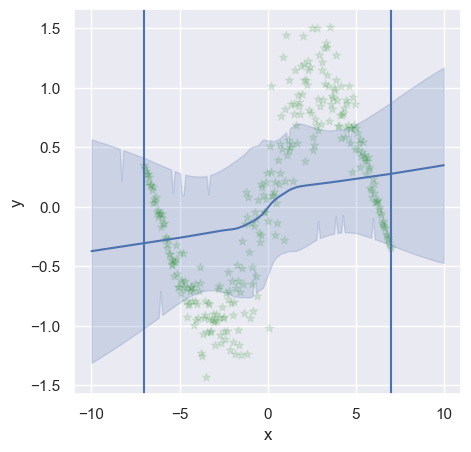

Epoch 10 | batch train loss: -0.6166189670562744 | test loss: 0.0817668164578768


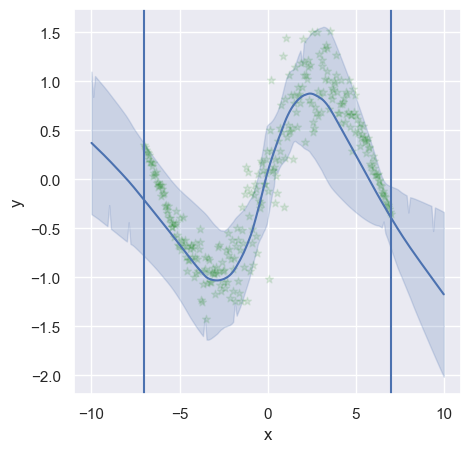

Epoch 20 | batch train loss: -0.9625902533531189 | test loss: 0.03532604288596373


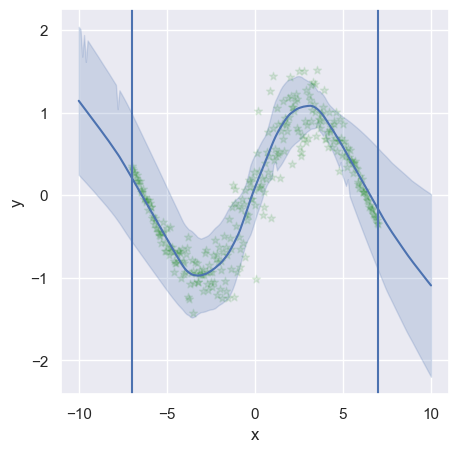

Epoch 30 | batch train loss: -1.2842598676681518 | test loss: -0.33381641621773056


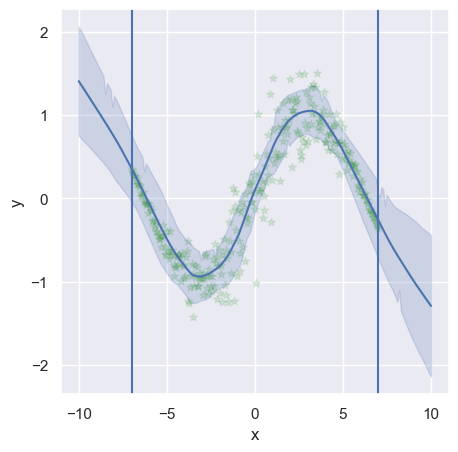

Epoch 40 | batch train loss: -1.2648692846298217 | test loss: -0.11855094203582175


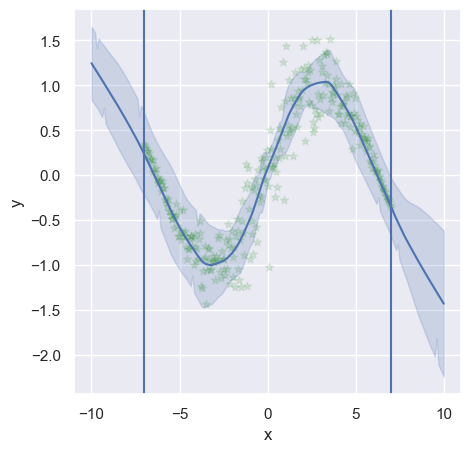

Epoch 50 | batch train loss: -1.3494553208351134 | test loss: -0.26903622924135284


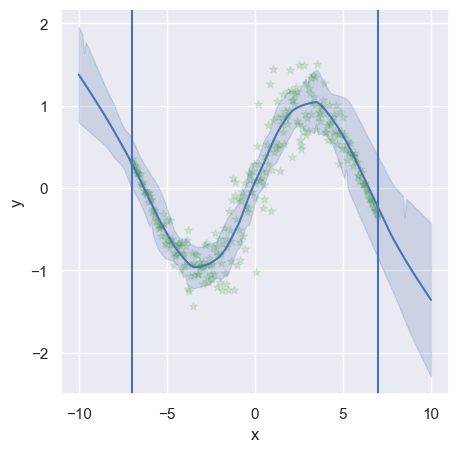

Epoch 60 | batch train loss: -1.1362232208251952 | test loss: 0.03203834100411486


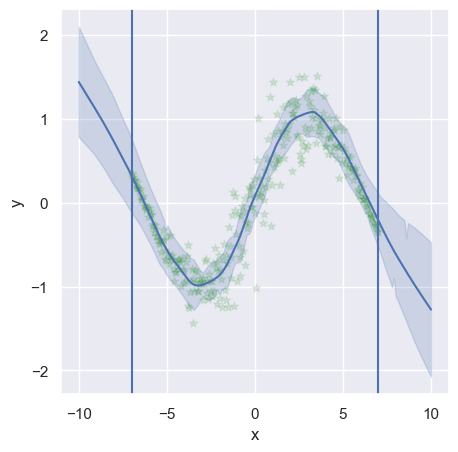

Epoch 70 | batch train loss: -0.9292682051658631 | test loss: 0.16350743644512614


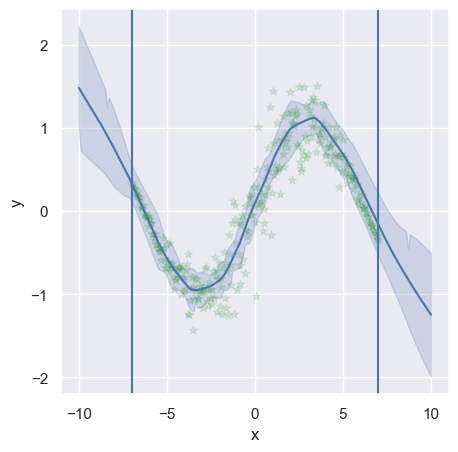

Epoch 80 | batch train loss: -1.2251021146774292 | test loss: 0.5149422077032236


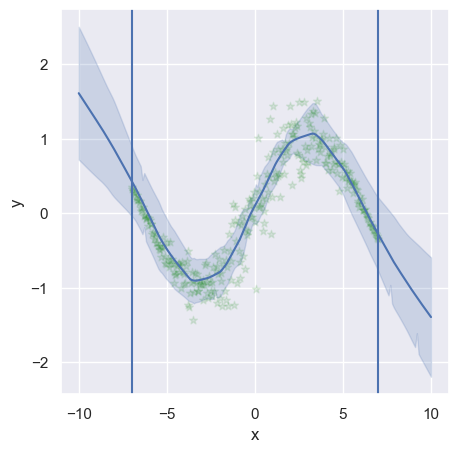

Epoch 90 | batch train loss: -1.0247658967971802 | test loss: 1.2287660672114447


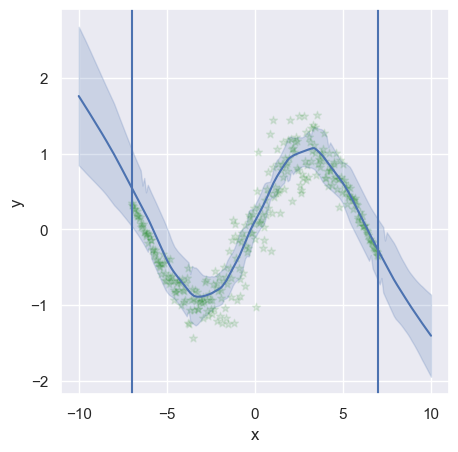

Epoch 100 | batch train loss: -1.4634276151657104 | test loss: 0.6690893766398613


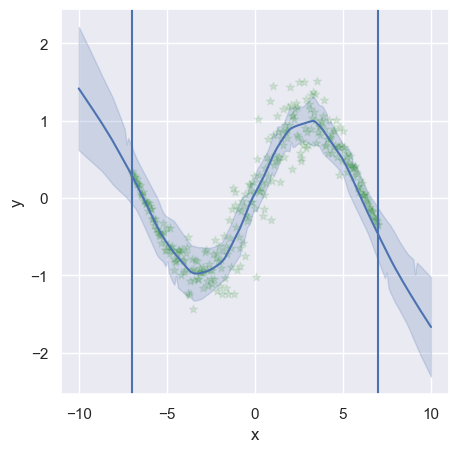

Epoch 110 | batch train loss: -1.0817573547363282 | test loss: 0.41184745201697714


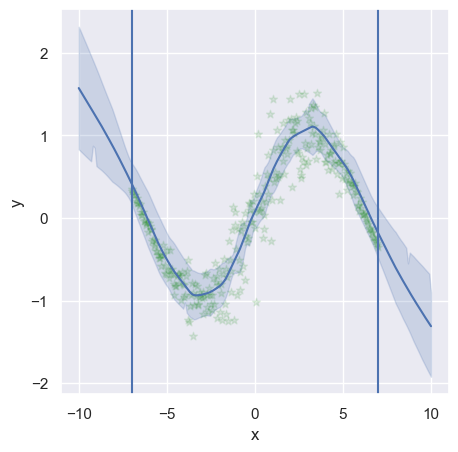

Epoch 120 | batch train loss: -1.3142133474349975 | test loss: 0.3397606168801967


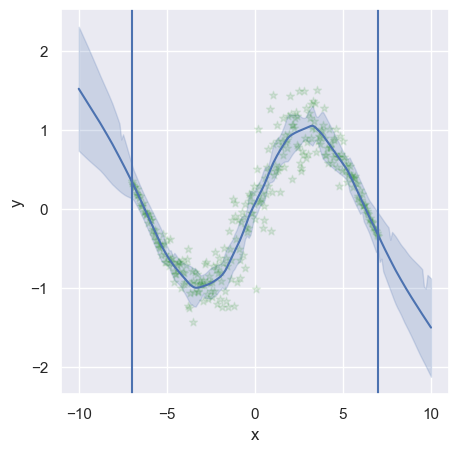

Epoch 130 | batch train loss: -0.8270222306251526 | test loss: 1.4205149956620653


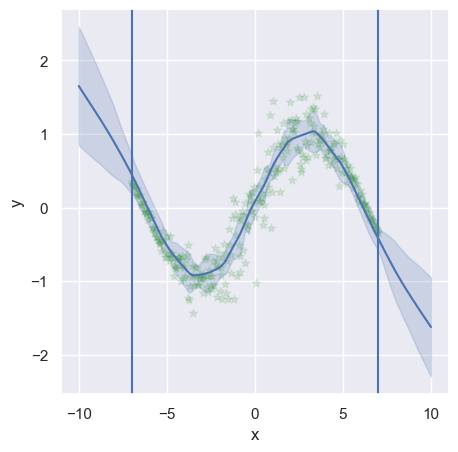

Epoch 140 | batch train loss: -1.4766916275024413 | test loss: 0.4028381909315402


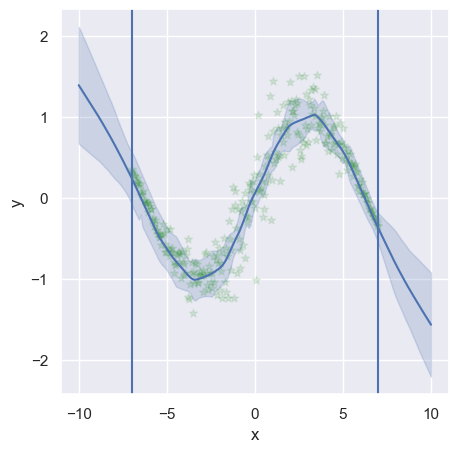

Epoch 150 | batch train loss: -1.284074568748474 | test loss: 0.5771671093427218


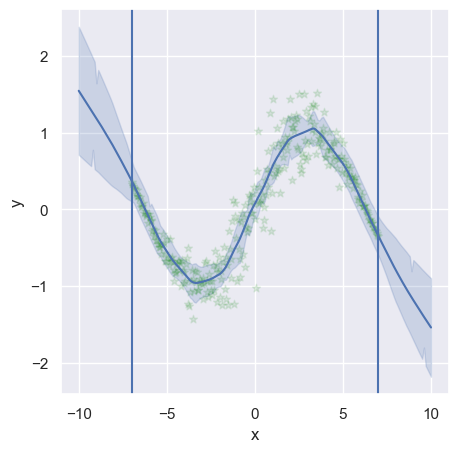

Epoch 160 | batch train loss: -1.0515664935112 | test loss: 0.3993734428515801


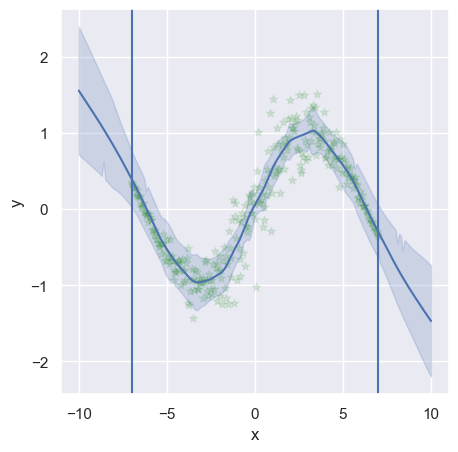

Epoch 170 | batch train loss: -0.6014746308326722 | test loss: 0.902525386443505


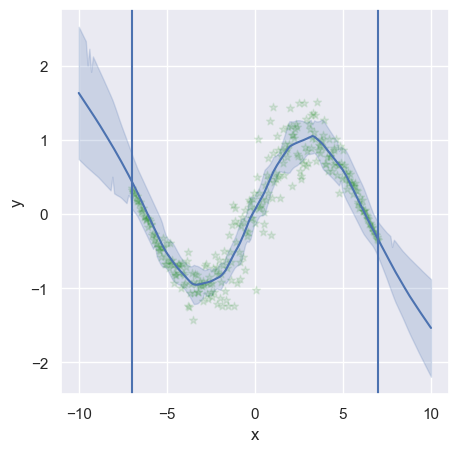

Epoch 180 | batch train loss: -1.3324419498443603 | test loss: 0.3398968350428801


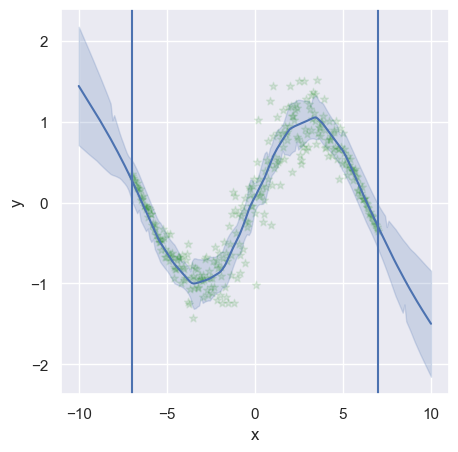

Epoch 190 | batch train loss: -1.4730576753616333 | test loss: 0.7677741823288109


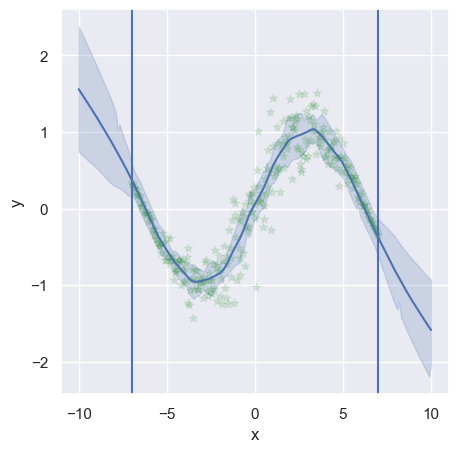

In [79]:
for epoch in range(200):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        losses = []
        mus = []
        vars = []
        for i, model in enumerate(deep_ensemble):
            optimizers[i].zero_grad()
            mu, var = model(x)
            loss = criterion(mu, y, var)
            loss.backward()
            optimizers[i].step()

            losses.append(loss.item())
            mus.append(mu)
            vars.append(var)
        loss = sum(losses)/len(losses)

    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            test_losses = []
            mus = []
            vars = []
            for i, model in enumerate(deep_ensemble):
                optimizers[i].zero_grad()
                mu, var = model(x)
                test_loss = criterion(mu, y, var)
                optimizers[i].step()

                test_losses.append(test_loss.item())
                mus.append(mu)
                vars.append(var)
            all_test_losses.append((sum(test_losses)/len(test_losses)))
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot_de(deep_ensemble)